In [45]:
import numpy as np
from qiskit import Aer
from qiskit.visualization import plot_histogram
from qiskit.utils import QuantumInstance
from qiskit.algorithms import Grover, AmplificationProblem
from qiskit.circuit.library import PhaseOracle

In [57]:
with open('3sat.dimacs', 'r') as f:
    dimacs = f.read()
print(dimacs)
"""
3sat.dimacs file contents

dimacs = c example DIMACS-CNF 3-SAT
p cnf 3 3
1 2 -3 0
-1 -2 -3 0
-1 2 3 0

"""

c example DIMACS-CNF 3-SAT
p cnf 3 3
1 2 -3 0
-1 -2 -3 0
-1 2 3 0


'\n3sat.dimacs file contents\n\ndimacs = c example DIMACS-CNF 3-SAT\np cnf 3 3\n1 2 -3 0\n-1 -2 -3 0\n-1 2 3 0\n\n'

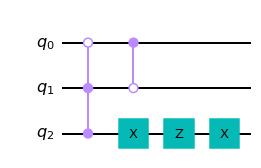

In [58]:
# Oracle's circuit
oracle = PhaseOracle.from_dimacs_file('3sat.dimacs')
oracle.draw(output='mpl')

In [59]:
# Verifier
class Verifier():
    """Create an object that can be used to check whether
    an assignment satisfies a DIMACS file.
        Args:
            dimacs_file (str): path to the DIMACS file
    """
    def __init__(self, dimacs_file):
        with open(dimacs_file, 'r') as f:
            self.dimacs = f.read()

    def is_correct(self, guess):
        """Verifies a SAT solution against this object's
        DIMACS file.
            Args:
                guess (str): Assignment to be verified.
                             Must be string of 1s and 0s.
            Returns:
                bool: True if `guess` satisfies the
                           problem. False otherwise.
        """
        # Convert characters to bools & reverse
        guess = [bool(int(x)) for x in guess][::-1]
        for line in self.dimacs.split('\n'):
            line = line.strip(' 0')
            clause_eval = False
            for literal in line.split(' '):
                if literal in ['p', 'c']:
                    # line is not a clause
                    clause_eval = True
                    break
                if '-' in literal:
                    literal = literal.strip('-')
                    lit_eval = not guess[int(literal)-1]
                else:
                    lit_eval = guess[int(literal)-1]
                clause_eval |= lit_eval
            if clause_eval is False:
                return False
        return True

In [60]:
v = Verifier('3sat.dimacs')   
v.is_correct('111')

False

In [65]:
#Implement Grover's algorithm to solve the problem
# Configure backend
backend = Aer.get_backend('aer_simulator')
quantum_instance = QuantumInstance(backend, shots=1024*4)

# Create a new problem from the phase oracle and the
# verification function
problem = AmplificationProblem(oracle=oracle, is_good_state=v.is_correct)

# Use Grover's algorithm to solve the problem
grover = Grover(quantum_instance=quantum_instance)
result = grover.amplify(problem)

result.top_measurement


'010'

In [63]:
result.circuit_results

[{'110': 1, '001': 2, '100': 5, '111': 2},
 {'001': 3, '111': 3, '100': 4},
 {'111': 1, '001': 4, '110': 1, '000': 2, '100': 2},
 {'011': 1, '101': 4, '110': 2, '000': 3}]

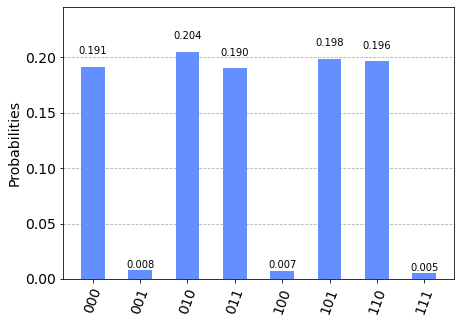

In [68]:
plot_histogram(result.circuit_results[-1])

# Sol: 000, 010, 011, 101, 110